In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vehicle-dataset-from-cardekho/car data.csv
/kaggle/input/vehicle-dataset-from-cardekho/CAR DETAILS FROM CAR DEKHO.csv
/kaggle/input/vehicle-dataset-from-cardekho/Car details v3.csv


## Steps I followed:
1. Importing data
2. Cleaning data and data exploration
3. Feature engineering (choosing required features)
4. Data visualization
5. Finding if there exists corr among variables
6. train test split
7. Model building and Hyper-parameter tuning
8. using various sklearn.metrics : mean_absolute_error, mean_squared_error, np.sqrt(mean_squared_error)
9. converting the model to pickle file for future use

In [2]:
# Importing Dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

In [3]:
# Importing data
dataset = pd.read_csv("../input/vehicle-dataset-from-cardekho/car data.csv")

# About features
1. **name** - Name of the cars
2. **year** - Year of the car when it was bought
3. **selling_price** - Price at which the car is being sold
4. **km_driven** - Number of Kilometres the car is driven
5. **fuel** - Fuel type of car
6. **seller_type** - tells if a seller is individual or a dealer
7. **transmission** - Gear transmission fo the car
8. **owner** - Number of previous owners of the car

In [4]:
# top 5-rows of dataset
dataset.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [5]:
# getting more familier with the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


### Selling_Price is the target feature

# Missing Values

In [6]:
# Checking if there is any missing value
dataset.isnull().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

# Categorical Variable Encoding

In [7]:
cat_features = [feature for feature in dataset.columns if dataset[feature].dtypes in ['object']]
cat_features

['Car_Name', 'Fuel_Type', 'Seller_Type', 'Transmission']

### Categorical feature distribution with 'Selling_Price'

In [8]:
dataset.shape

(301, 9)

In [9]:
dataset.Car_Name.nunique()
# There are 98 different features

98

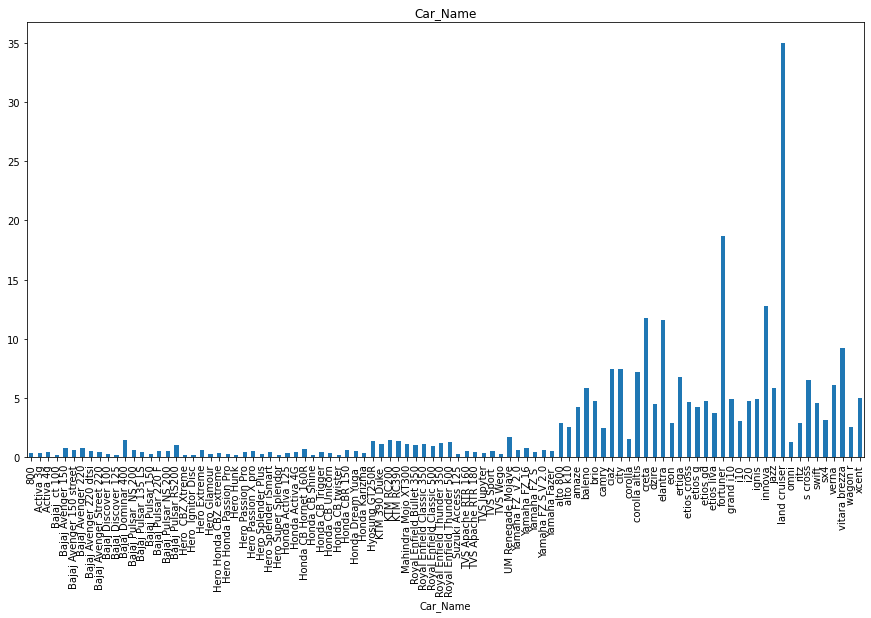

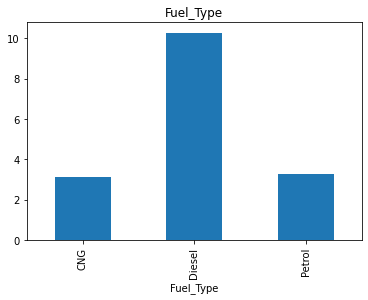

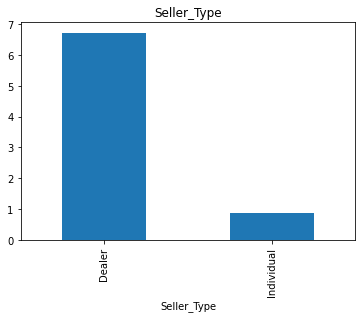

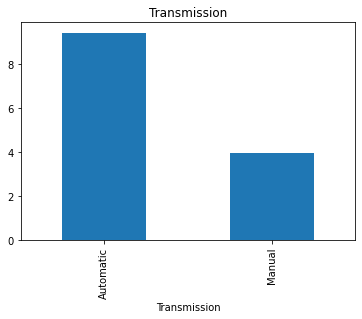

In [10]:
# Mean prices per category of categorical variables
plt.figure(figsize=(15,8))
for feature in cat_features:
    dataset.groupby(feature)['Selling_Price'].mean().plot.bar()
    plt.title(feature)
    plt.show()

#### Observation of categorical features
1. Few car names have higher prices, like 'fortuner', 'innova', 'land cruiser', etc.
2. In Fuel_Type, 'Diesel' type cars have higher prices as compared to CNG or Petrol driven cars
3. In seller_type, 'Dealer' are selling cars with higher prices than 'Individual'
4. And finally, 'Automatic' cars are being sold for higher prices than 'Manual' cars

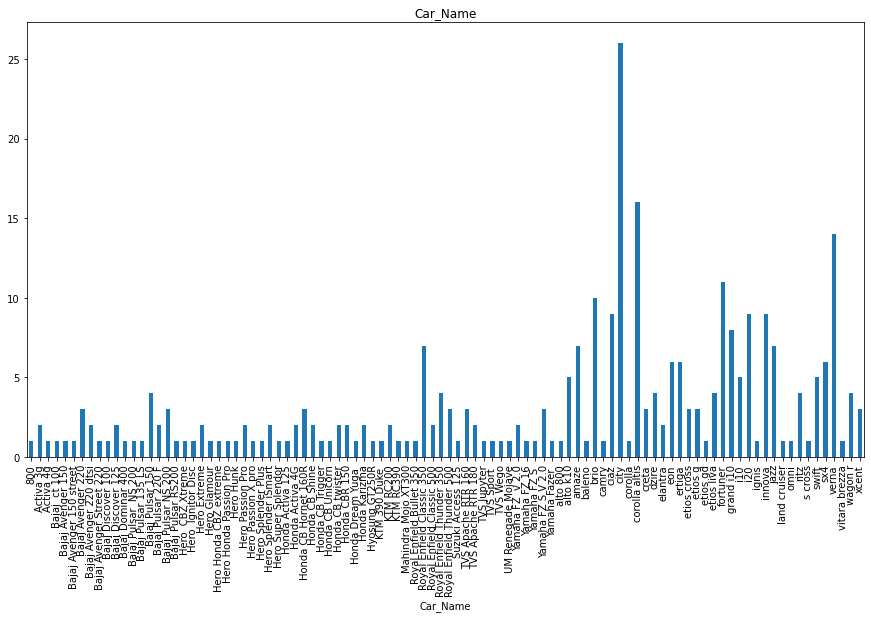

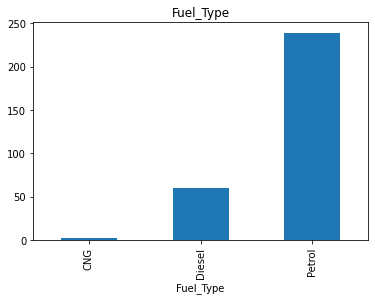

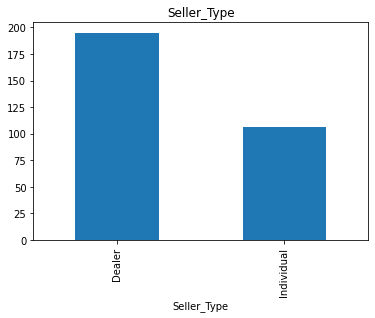

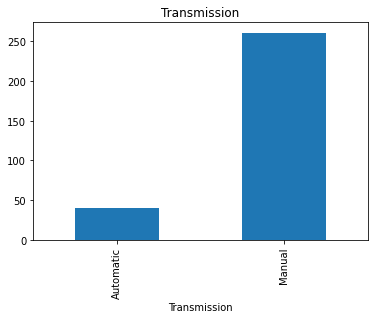

In [11]:
# count of prices per category of categorical variables
plt.figure(figsize=(15,8))
for feature in cat_features:
    dataset.groupby(feature)['Selling_Price'].count().plot.bar()
    plt.title(feature)
    plt.show()

# Temporal Feature: Features releted to time, date or year

In [12]:
temporal_feature = [feature for feature in dataset.columns if 'year' in feature.lower() or 'yr' in feature.lower()]
temporal_feature

['Year']

##### Updating the temporal feature with number years since the car was bought

In [13]:
for feature in temporal_feature:
    dataset[feature] = 2021 - dataset[feature]

In [14]:
dataset.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,7,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,8,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,4,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,10,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,7,4.60,6.87,42450,Diesel,Dealer,Manual,0


#### Now 'year' variable represents the number of years passed since the car was bought

# Numerical Variables

##### finding correlation between all the numerical values with target variable Selling_Price

In [15]:
dataset.corr()['Selling_Price'].drop('Selling_Price', axis=0) # pandas.core.frame.DataFrame

Year            -0.236141
Present_Price    0.878983
Kms_Driven       0.029187
Owner           -0.088344
Name: Selling_Price, dtype: float64

##### Observation: The Selling_Price is linearly directly correlated with Present_Price

In [16]:
dataset[['Year', 'Present_Price',  'Kms_Driven', 'Owner']].head()

,Year,Present_Price,Kms_Driven,Owner
0,7,5.59,27000,0
1,8,9.54,43000,0
2,4,9.85,6900,0
3,10,4.15,5200,0
4,7,6.87,42450,0


In [17]:
# Checking the number of unique values present per numerical variable
dataset[['Year', 'Present_Price',  'Kms_Driven', 'Owner']].nunique()

Year              16
Present_Price    147
Kms_Driven       206
Owner              3
dtype: int64

In [18]:
dataset[['Year', 'Present_Price',  'Kms_Driven', 'Owner']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           301 non-null    int64  
 1   Present_Price  301 non-null    float64
 2   Kms_Driven     301 non-null    int64  
 3   Owner          301 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 9.5 KB


##### Although 'Kms_Driven' is of type int64, but it should be continuous numerical variable

In [19]:
# Changing the datatype of Kms_driven
dataset.Kms_Driven = dataset.Kms_Driven.astype('float64')

In [20]:
dataset[['Year', 'Present_Price',  'Kms_Driven', 'Owner']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           301 non-null    int64  
 1   Present_Price  301 non-null    float64
 2   Kms_Driven     301 non-null    float64
 3   Owner          301 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 9.5 KB


### Discrete Numerical Variables

In [21]:
discrete_num_features = [feature for feature in dataset.columns if dataset[feature].dtypes in ['int64']]
discrete_num_features

['Year', 'Owner']

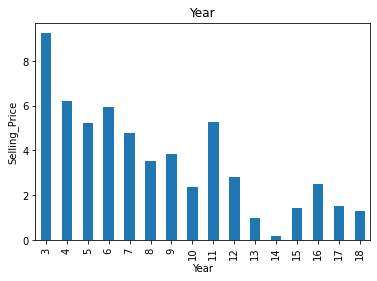

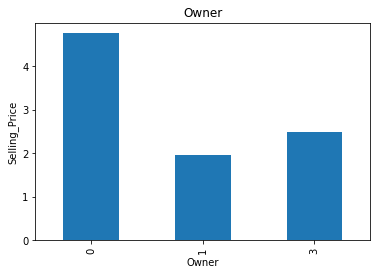

In [22]:
# Let's see the relationship of discrete numerical variables with target variable ('SalePrice')
for feature in discrete_num_features:
    dataset.groupby(feature)['Selling_Price'].mean().plot.bar()

    plt.xlabel(feature)
    plt.ylabel('Selling_Price')
    plt.title(feature)
    plt.show()

##### Observations: 
1. With the increase in the number of years, we can see a clear decline in Selling Price
2. In case of Owner, if there was no previous (0 owner) the selling price is highest, but the 3 owner mean > 1 onwer; we need to check the median value here

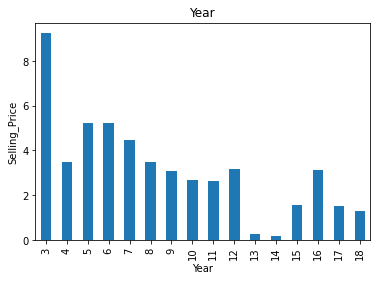

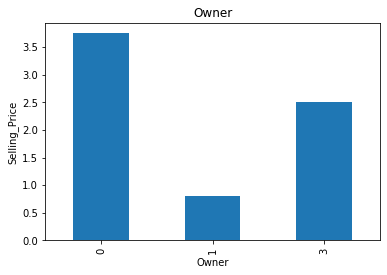

In [23]:
# Let's see the relationship of discrete numerical variables with target variable ('SalePrice')
for feature in discrete_num_features:
    dataset.groupby(feature)['Selling_Price'].median().plot.bar()

    plt.xlabel(feature)
    plt.ylabel('Selling_Price')
    plt.title(feature)
    plt.show()

##### Observations: 
1. With the increase in the number of years, we can see a clear decline in Selling Price
2. In case of Owner, if there was no previous (0 owner) the selling price is highest, but the 3 owner meadian > 1 onwer median.

### Continuous Numerical Variables

In [24]:
continuous_num_features = [feature for feature in dataset.columns if dataset[feature].dtypes == 'float64']
continuous_num_features

['Selling_Price', 'Present_Price', 'Kms_Driven']

In [25]:
# dropping target variable from continuous_num_features list
continuous_num_features.remove('Selling_Price')
continuous_num_features

['Present_Price', 'Kms_Driven']

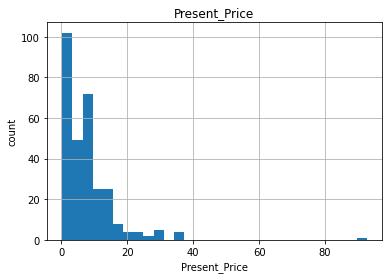

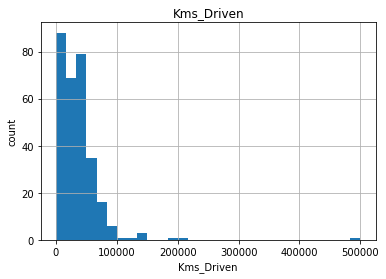

In [26]:
# Let's analyse the continuous values by creating histograms to understand the distribution
for feature in continuous_num_features:
    dataset[feature].hist(bins=30)
    plt.xlabel(feature)
    plt.ylabel('count')
    plt.title(feature)
    plt.show()

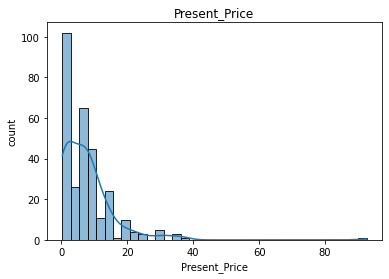

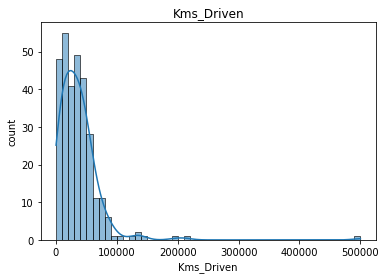

In [27]:
# Let's analyse the continuous values by creating histograms to understand the distribution
for feature in continuous_num_features:
    sns.histplot(data=dataset, x=feature, kde=True)
    plt.xlabel(feature)
    plt.ylabel('count')
    plt.title(feature)
    plt.show()

##### Obseravation: Continuous variables are right skewed (mode < median < mean)

### Outliers : Checking outliers in numerical variables

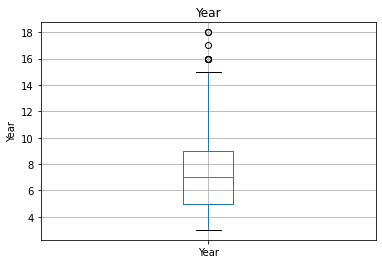

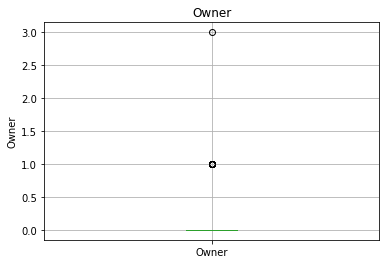

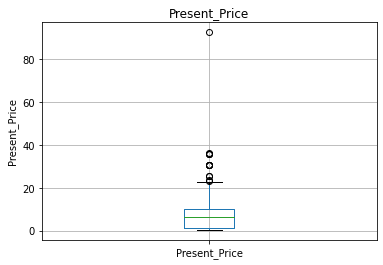

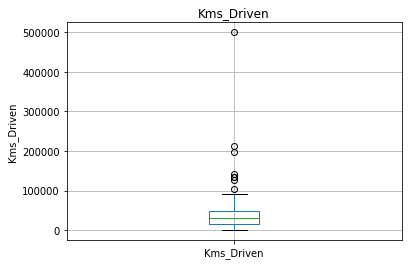

In [28]:
# boxplot to visualize outliers

for feature in discrete_num_features + continuous_num_features:
    dataset.boxplot(column = feature)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

##### Observations: All the numerical variables have outliers. Had there been any missing values, we would have replaced with median() instead of mean()

# Splitting Data

In [29]:
X = dataset.drop('Selling_Price', axis=1)
y = dataset.Selling_Price
X.head()

,Car_Name,Year,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,7,5.59,27000.0,Petrol,Dealer,Manual,0
1,sx4,8,9.54,43000.0,Diesel,Dealer,Manual,0
2,ciaz,4,9.85,6900.0,Petrol,Dealer,Manual,0
3,wagon r,10,4.15,5200.0,Petrol,Dealer,Manual,0
4,swift,7,6.87,42450.0,Diesel,Dealer,Manual,0


# Categorical variable Encoding
### Label encoding and One-hot encoding

#### Label Encoding for Fuel_Type, Seller_Type, Transmission

In [30]:
# label encoding
car_dataset = X.copy()
car_dataset.replace({'Fuel_Type':{'Petrol':3, 'Diesel':1, 'CNG':2}}, inplace=True)
car_dataset.replace({'Seller_Type':{'Dealer':1, 'Individual':2}}, inplace=True)
car_dataset.replace({'Transmission':{'Manual':2, 'Automatic':1}}, inplace=True)

# Train - Test Split

In [31]:
x_train, x_test, y_train, y_test = train_test_split(car_dataset, y, random_state=1, test_size=0.1)

### One-hot encoding for Car-Name

In [32]:
x_train.head()

,Car_Name,Year,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
197,Honda CB twister,11,0.51,33000.0,3,2,2,0
202,grand i10,6,5.70,28200.0,3,1,2,0
59,fortuner,7,35.96,41000.0,1,1,1,0
51,fortuner,6,30.61,40000.0,1,1,1,0
89,etios g,7,6.76,40000.0,3,1,2,0


In [33]:
# 'handle_unknown' helps to discard categories not seen during fit
encoder_OH = OneHotEncoder(handle_unknown = 'ignore', sparse=False)

train_encoded = pd.DataFrame(encoder_OH.fit_transform(x_train[['Car_Name']]), index = x_train.index)
test_encoded = pd.DataFrame(encoder_OH.transform(x_test[['Car_Name']]), index = x_test.index)

train_OH = pd.concat([x_train.select_dtypes(include = ['int64', 'float64']), train_encoded], axis = 1)
test_OH = pd.concat([x_test.select_dtypes(include = ['int64', 'float64']), test_encoded], axis = 1)

In [34]:
print(train_OH.shape)
print(test_OH.shape)
# total number of features = 101

(270, 101)
(31, 101)


### Feature Selection

In [35]:
# Next setps:
#     1. feature scaling 
#     2. feature selection using lasso and select from model
#     3. model building using treebase ensemble models randomforest, extra tree, xgboost
#     4. use of randomized search cv for hyperparameter tuning
#     5. selecting the best model out of them
#     6. printing the test score

In [36]:
train_cols = train_OH.columns

# MinMax scaler object
scaler = MinMaxScaler()

# transforming train data
x_train_encoded_scaled = pd.DataFrame(scaler.fit_transform(train_OH), columns = train_cols)

# transforming test data
x_test_encoded_scaled = pd.DataFrame(scaler.transform(test_OH), columns = train_cols)

## Feature Selection using Lasso regression to select important features
#### This is the reason why I performed feature scaling

In [37]:
# The bigger the alpha for Lasso, less features gets selected
# SelectFromModel selects features whose coefficients are non-zero
# feature selection using training data
feature_sel = SelectFromModel(Lasso(alpha = 0.01, random_state=1, max_iter=10000))
feature_sel.fit(x_train_encoded_scaled, y_train)

selected_features = x_train_encoded_scaled.columns[feature_sel.get_support()]
len(selected_features)

24

##### Out of 101 features, only 24 got selected

In [38]:
np.array(selected_features)

array(['Year', 'Present_Price', 'Kms_Driven', 'Fuel_Type', 'Seller_Type',
       'Transmission', 0, 14, 27, 28, 29, 30, 44, 60, 61, 64, 65, 67, 68,
       70, 71, 77, 82, 90], dtype=object)

# Model building

### Refer below articles to know more about Tree based algorithms
### [Decision trees and ensemble methods do not require feature scaling to be performed as they are not sensitive to the the variance in the data]("https://towardsdatascience.com/do-decision-trees-need-feature-scaling-97809eaa60c6")

### [ExtraTreesRegressor vs RandomForestRegressor]("https://quantdare.com/what-is-the-difference-between-extra-trees-and-random-forest/")

In [39]:
# # ExtraTreesRegressor and RandomForestRegressor have exactly same set of parameters,

# Important differences among them exists as below:
    # 1. Random forest uses bootstrap replicas (bootstrap == True), i.e., it subsamples the input data with replacement. 
    # But Extra Trees uses the whole original samples (bootstrap == False).

    # 2. Random forest chooses optimum split for splitting nodes (computationally costly), but ExtraTrees chooses splits randomly

In [40]:
# Considering features selected using lasso regression
x_train_final = train_OH[selected_features]
x_test_final = test_OH[selected_features]

In [41]:
x_train_final.head()

,Year,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,0,14,27,28,...,61,64,65,67,68,70,71,77,82,90
197,11,0.51,33000.0,3,2,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202,6,5.70,28200.0,3,1,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,7,35.96,41000.0,1,1,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
51,6,30.61,40000.0,1,1,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
89,7,6.76,40000.0,3,1,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Hyper-parameter Tuning

In [42]:
params_ET_RF = {
'n_jobs' : [-1],
'n_estimators' : [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200],
'criterion' : ['mse', 'mae'],
'max_depth' : [5, 10, 15, 20, 25, 30],
'max_features' : ['auto', 'sqrt'],
'min_samples_split' : [2, 5, 10, 15, 100],
'min_samples_leaf' : [1, 2, 5, 10]
}

params_XGBRegressor = {
'n_jobs' : [-1],
'learning_rate' : [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
'max_depth' : [3,4,5,6,8,10,12,15],
'n_estimators' : [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200],
"min_child_weight" : [1,3,5,7],
"gamma" : [0.0, 0.1, 0.2, 0.3, 0.4],
"colsample_bytree" : [0.3, 0.4, 0.5, 0.6]
}


In [43]:
regressors = [ExtraTreesRegressor(), RandomForestRegressor(), xgb.XGBRegressor()]
params = [params_ET_RF, params_ET_RF, params_XGBRegressor]
names = ['ExtraTreesRegressor', 'RandomForestRegressor', 'XGBRegressor']
# looping through each regressor
for i in range(3):
    cv_regressor = RandomizedSearchCV(regressors[i], param_distributions = params[i], n_iter = 5, scoring = 'neg_mean_squared_error', n_jobs=-1, cv = 5)
    # scorings='roc_auc' for classification problems
    # scorings='neg_mean_squared_error' for regression problems

    cv_regressor.fit(x_train_final,y_train)

    print("************",names[i],"************")
    print("Best estimators: \n {}".format(cv_regressor.best_estimator_))
    print()
    print("Best score: \n {}".format(cv_regressor.best_score_))
    print()
    print("Best parameters: \n {}".format(cv_regressor.best_params_))
    print()
    print()

************ ExtraTreesRegressor ************
Best estimators: 
 ExtraTreesRegressor(criterion='mae', max_depth=25, max_features='sqrt',
                    min_samples_split=5, n_estimators=400, n_jobs=-1)

Best score: 
 -4.5218445603975805

Best parameters: 
 {'n_jobs': -1, 'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25, 'criterion': 'mae'}


************ RandomForestRegressor ************
Best estimators: 
 RandomForestRegressor(max_depth=30, min_samples_split=10, n_jobs=-1)

Best score: 
 -3.7417080200209027

Best parameters: 
 {'n_jobs': -1, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'criterion': 'mse'}


************ XGBRegressor ************
Best estimators: 
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_co

##### XGBRegressor performed best

### Final Prediction

In [44]:
# defination of final model
final_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=5,  monotone_constraints='()',
             n_estimators=1100, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# fitting and prediction
final_model.fit(x_train_final, y_train)
predictions = final_model.predict(x_test_final)

## Performance Metrics

In [45]:
from sklearn import metrics

# performance metrices
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))


import pickle
# open a file, where you ant to store the data
file = open('final_model.pkl', 'wb')

# dump information to that file
pickle.dump(final_model, file)

MAE: 0.8275096783907183
MSE: 2.2146206745802117
RMSE: 1.4881601642901923
